In [30]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

In [31]:
# 1. Randomly initialize all D_ij
# 2. Set p_T = 0
# 3. Deduce all other p_i
# 4. Calculate Q_ij
# 5. t = t+1

In [32]:
# constants

# note: node 0 is source, node N is sink
N = 6
delta = 0.1
n_sim = 100
I_0 = 1.0
INF = 1e9
mu = 2

maze = [
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1],
    [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
    [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
    [1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
    [1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1],
    [1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]
]

L = np.array([
    [INF, 1.4, 1.0, INF, INF, INF],
    [1.4, INF, 1, 2.24, INF, INF],
    [1, 1, INF, 2, 2.24, INF],
    [INF, 2.24, 2, INF, 1, 1],
    [INF, INF, 2.24, 1, INF, 1.4],
    [INF, INF, INF, 1, 1.4, INF]
])

def f(x):
    return x**mu

In [33]:
def maze_to_graph(maze):
    global INF
    N = 0
    mc = maze
    start = (INF, INF)
    end = (INF, INF)
    
    ind_N = 1
    ind = np.zeros((len(maze), len(maze[0])))-1
    
    for x in range(len(maze)):
        for y in range(len(maze[0])):
            if(maze[x][y]==0):
                N = N+1
                
                if x==0 or y==0 or x==len(maze)-1 or y==len(maze[0])-1:
                    if start[0] == INF:
                        start = (x, y)
                        ind[x][y] = 0
                    else:
                        end = (x, y)
                else:
                    ind[x][y] = ind_N
                    ind_N = ind_N+1
    
    L = INF * np.ones((N, N))
    ind[end[0]][end[1]] = N-1
    for i in range(len(maze)):
        for j in range(len(maze[0])):
            if ind[i][j]!=-1:
                for (dx, dy) in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                    x = i + dx
                    y = j + dy
                    if 0 <= x and x < len(maze) and 0 <= y and y < len(maze[0]):
                        if maze[x][y] == 0:
                            L[int(ind[i][j])][int(ind[x][y])] = 1
    return (N, L)
(N, L) = maze_to_graph(maze)

In [34]:
# verify matrix is symmetric
for i in range(N):
    for j in range(N):
        if L[i][j] != L[j][i]:
            raise Exception('Graph is not symmetric')
        if i==j and L[i][j]!=INF:
            raise Exception('Diagonal is not zeroes')

D = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        if L[i][j] < INF and j>i:
            D[i][j] = random.uniform(0.5, 1)
        elif i>j:
            D[i][j] = D[j][i]
        else:
            D[i][j] = 0

In [35]:
def show(maze, D, p):
    global INF
    
    N = D.shape[0]
    arr = -1*np.ones((len(maze), len(maze[0])))
    maze_big = -1*np.ones((len(maze)*2-1, len(maze[0])*2-1))
    start = (INF, INF)
    end = (INF, INF)
    ind_N = 1
    for x in range(len(maze)):
        for y in range(len(maze[0])):
            if(maze[x][y]==0):                
                if x==0 or y==0 or x==len(maze)-1 or y==len(maze[0])-1:
                    if start[0] == INF:
                        start = (x, y)
                        arr[x][y] = 0
                    else:
                        arr[x][y] = N-1
                else:
                    arr[x][y] = ind_N
                    ind_N = ind_N+1

    for x in range(len(maze)):
        for y in range(len(maze[0])):
            tot = 0
            cnt = 0
            for (dx, dy) in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                xc = x + dx
                yc = y + dy

                if 0 <= xc and xc < len(maze) and 0 <= yc and yc < len(maze[0]):
                    if arr[x][y] != -1 and arr[xc][yc]!=-1:
                        maze_big[2*x+dx][2*y+dy] = D[int(arr[x][y])][int(arr[xc][yc])]
                        tot += maze_big[2*x+dx][2*y+dy]
                        cnt += 1
            if arr[x][y] != -1:
                maze_big[2*x][2*y] = tot/cnt
    maze_big = maze_big/np.amax(maze_big)
    return maze_big

In [36]:
def constraint(C, j):
    constr = np.zeros((N,))
    for i in range(N):
        if C[i][j] > 0:
            constr[i] += C[i][j]
            constr[j] -= C[i][j]
    return constr

def solve_pressure(D):
    lineq = np.zeros((N, N))
    dep = np.zeros((N,))
     
    C = D/L
    
    # add source constraint \sum_{i\in V(0)} Q_i = \sum_{i\in V(0)} C_i0 (p_i-p_0) = -I_0
    lineq[0] = constraint(C, 0)
    dep[0] = -I_0
    
    lineq[N-1] = constraint(C, N-1)
    dep[N-1] = I_0
    
    
    for j in range(1, N-1):
        lineq[j] = constraint(C, j)
        
#    print(lineq @ np.array([ 1.44939475,  0.51167369,  0.42142306, -0.54948685, -0.52652166,
#       -1.30648298]))
    p = np.linalg.lstsq(np.array(lineq), np.array(dep), rcond=None)[0]
    Q = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            Q[i][j] = C[i][j]*(p[i]-p[j])
    return (p, Q)

In [37]:
Q = solve_pressure(D)[1]

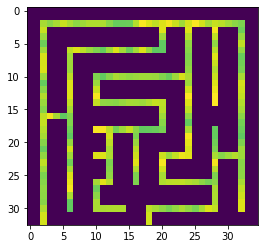

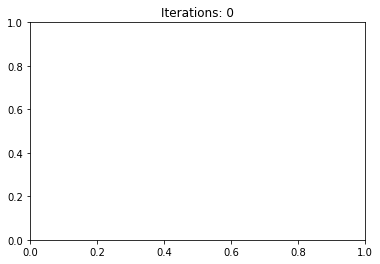

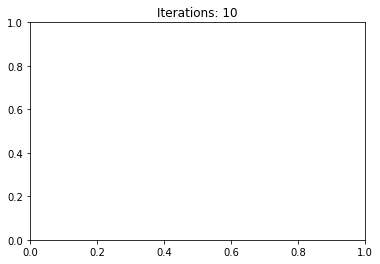

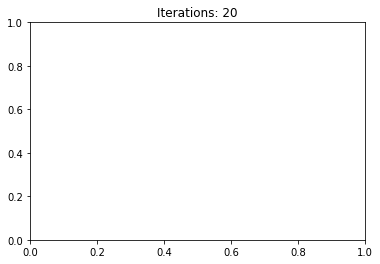

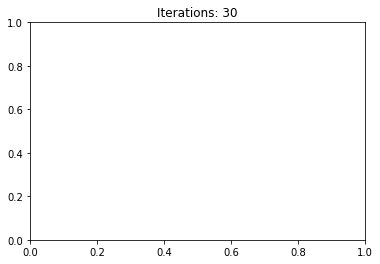

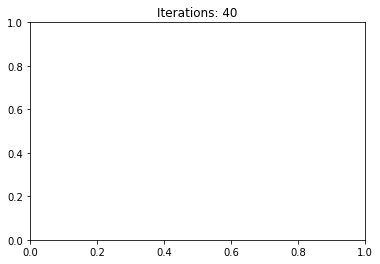

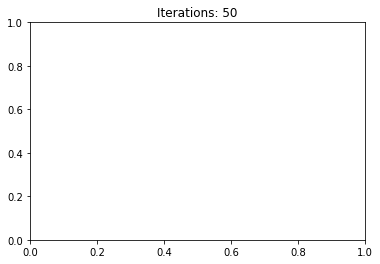

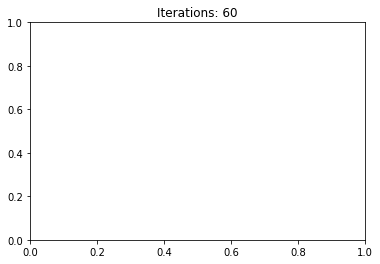

KeyboardInterrupt: 

In [38]:
fg = plt.imshow(show(maze, D, solve_pressure(D)[0]))
plt.show(block=False)
plt.pause(1)
for i in tqdm(range(1000)):
    delta_D = f(abs(Q)) - D
    D = D + delta * delta_D
    Q = solve_pressure(D)[1]
    if i % 10 == 0:
        plt.title('Iterations: ' + str(i))
        fg.set_data(show(maze, D, solve_pressure(D)[0]))
        plt.draw()
        plt.pause(0.001)

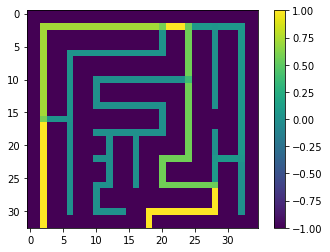

In [25]:
plt.imshow(show(maze, D, solve_pressure(D)[0]))
plt.colorbar()

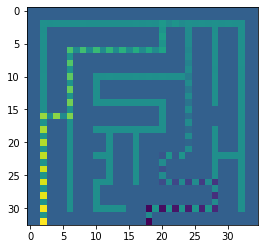

In [44]:
show(maze, solve_pressure(D)[1], solve_pressure(D)[0])

In [45]:
D

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

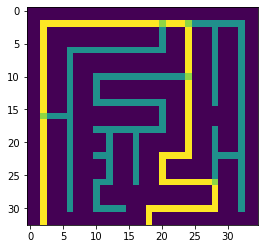

In [187]:
fig = plt.imshow(show(maze, D, solve_pressure(D)[0]))
fig.set_data(show(maze, D, solve_pressure(D)[0]))
plt.draw()